# Reinforcement Learning - Text Flappy Bird
**Zheng WAN**

## Import libraries

In [2]:
!pip install gymnasium -q
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 5.2 MB/s eta 0:00:00


In [3]:
import time
import random
import os, sys
import numpy as np
import gymnasium as gym
import text_flappy_bird_gym
from collections import deque, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

import warnings
warnings.filterwarnings('ignore')

## Environment & Helper functions

In [6]:
# Initiate Environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

In [11]:
def plot_q_tables(agent):
    x_coords = [dx for dx, dy in list(agent.q_tables.keys())]
    y_coords = [dy for dx, dy in list(agent.q_tables.keys())]
    colors = [np.argmax(agent.q_tables[(dx, dy)]) for dx, dy in list(agent.q_tables.keys())]

    scatter = plt.scatter(x_coords, y_coords, c=colors, cmap='coolwarm')

    plt.xlabel('Distance to Center of Next Pipe (dx)')
    plt.ylabel('Vertical Distance to Next Pipe (dy)')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    cbar = plt.colorbar(scatter, ticks=[0, 1])
    cbar.ax.set_yticklabels(['Idle', 'Flap'])
    plt.show()

## Expected SARSA

In [7]:
class ExpectedSarsaAgent():
    def __init__(self, agent_init_info):
        self.alpha = agent_init_info['alpha']
        self.alpha_decay = agent_init_info['alpha_decay']
        self.gamma = agent_init_info['gamma']
        self.epsilon = agent_init_info['epsilon']
        self.eps_decay = agent_init_info['eps_decay']
        self.q_tables = defaultdict(lambda: np.zeros(2))

    def act(self, state):
        if np.random.random() < self.epsilon:
            current_action = env.action_space.sample()
        else:
            current_action = np.argmax(self.q_tables[state])
        return current_action

    def update(self, state, action, next_state, next_action, reward):
        current_q = self.q_tables[state][action]
        next_q = self.q_tables[next_state][next_action]
        self.q_tables[state][action] = current_q + self.alpha * (reward + self.gamma * next_q - current_q)

        # Decay for the epsilon
        if self.epsilon > 0.0001:
            self.epsilon = max(self.epsilon * self.eps_decay, 0.0001)
        # Decay for the step-size
        if self.alpha > 0.1:
            self.alpha = max(self.alpha * self.alpha_decay, 0.1)

In [31]:
agent_init_info = {'epsilon' : 0.07, 'alpha' : 0.4, 'gamma' : 0.9, 'eps_decay':	1.0, 'alpha_decay': 1.0}
num_episodes = 25000
reward_sum = []

start = time.time()
agent_esarsa = ExpectedSarsaAgent(agent_init_info)
for i in range(num_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent_esarsa.act(state)
        next_state, reward, done, _, info = env.step(action)
        next_action = agent_esarsa.act(next_state)
        if done == True:
            reward = -1
        total_reward += reward
        agent_esarsa.update(state, action, next_state, next_action, reward)
        state = next_state
        if done:
            break
    if (i+1)%5000 == 0:
        print(f'epoch {i+1}')
    reward_sum.append(total_reward)
    env.close()
print(f'The mean cumulative reward obtained by the Expected SARSA agent: {np.mean(reward_sum)}\nExecution time: {np.round(time.time() - start, 2)}')

Episode 5000
Episode 10000
Episode 15000
Episode 20000
Episode 25000
The mean cumulative reward obtained by the Expected SARSA agent: 104.1812
Execution time: 66.3


**Performance Graphs**

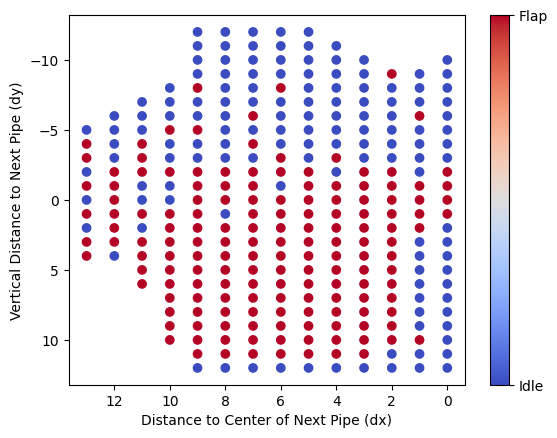

In [12]:
# Plot ESARSA agent's Q-table
plot_q_tables(agent_esarsa)

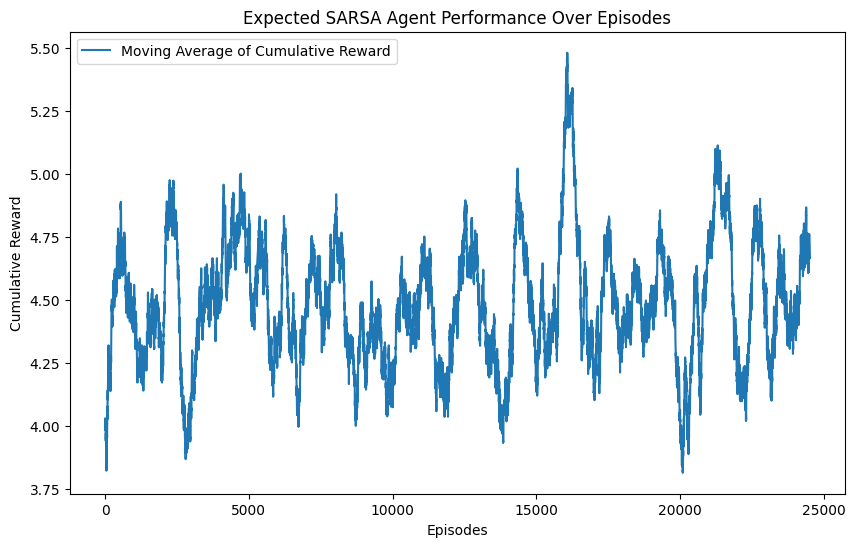

In [29]:
episodes = list(range(1, 25001))
reward_sum = [np.random.randint(-5, 15) for _ in episodes]  # Dummy data for demonstration

# Calculate moving average for smoother visualization
window_size = 500
moving_averages = []
for i in range(len(reward_sum) - window_size + 1):
    this_window = reward_sum[i : i + window_size]
    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episodes[: len(moving_averages)], moving_averages, label='Moving Average of Cumulative Reward')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Expected SARSA Agent Performance Over Episodes')
plt.legend()
plt.grid(False)  # Removing grid
plt.show()

## Q-learning

In [14]:
class QLearningAgent():
    def __init__(self, agent_init_info):
        self.alpha = agent_init_info['alpha']
        self.alpha_decay = agent_init_info['alpha_decay']
        self.gamma = agent_init_info['gamma']
        self.epsilon = agent_init_info['epsilon']
        self.eps_decay = agent_init_info['eps_decay']
        self.q_tables = defaultdict(lambda: np.zeros(2))

    def act(self, state):
        if np.random.random() < self.epsilon:
            current_action = env.action_space.sample()
        else:
            current_action = np.argmax(self.q_tables[state])
        return current_action

    def update(self, state, action, next_state, next_action, reward):
        old_q = self.q_tables[state][action]
        next_max = np.max(self.q_tables[next_state])
        self.q_tables[state][action] = (1 - self.alpha) * old_q + self.alpha * (reward + self.gamma * next_max)

        # Decay for the epsilon
        if self.epsilon > 0.0001:
            self.epsilon = max(self.epsilon * self.eps_decay, 0.0001)
        # Decay for the step-size
        if self.alpha > 0.1:
            self.alpha = max(self.alpha * self.alpha_decay, 0.1)

In [15]:
agent_init_info = {'epsilon' : 0.05, 'alpha' : 0.75, 'gamma' : 1.0, 'eps_decay':	0.99999, 'alpha_decay': 0.99999}
num_episodes = 25000
reward_sum = []

start = time.time()
agent_qlearning = QLearningAgent(agent_init_info)
for i in range(num_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent_qlearning.act(state)
        next_state, reward, done, _, info = env.step(action)
        next_action = agent_qlearning.act(next_state)
        if done == True:
            reward = -1
        total_reward += reward
        agent_qlearning.update(state, action, next_state, next_action, reward)
        state = next_state
        if done:
            break
    if (i+1)%5000 == 0:
        print(f'Episode {i+1}')
    reward_sum.append(total_reward)
    env.close()
print(f'The mean cumulative reward obtained by the Q-learning agent: {np.mean(reward_sum)}\nExecution time: {np.round(time.time() - start, 2)}')

Episode 5000
Episode 10000
Episode 15000
Episode 20000
Episode 25000
The mean cumulative reward obtained by the Q-learning agent: 148.95964
Execution time: 128.7


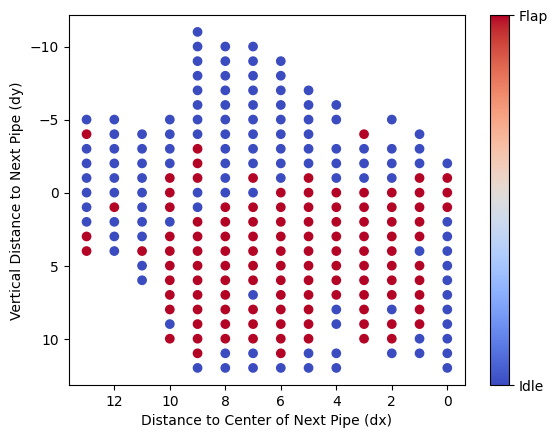

In [34]:
# Plot Q-learning agent's Q-table
plot_q_tables(agent_qlearning)

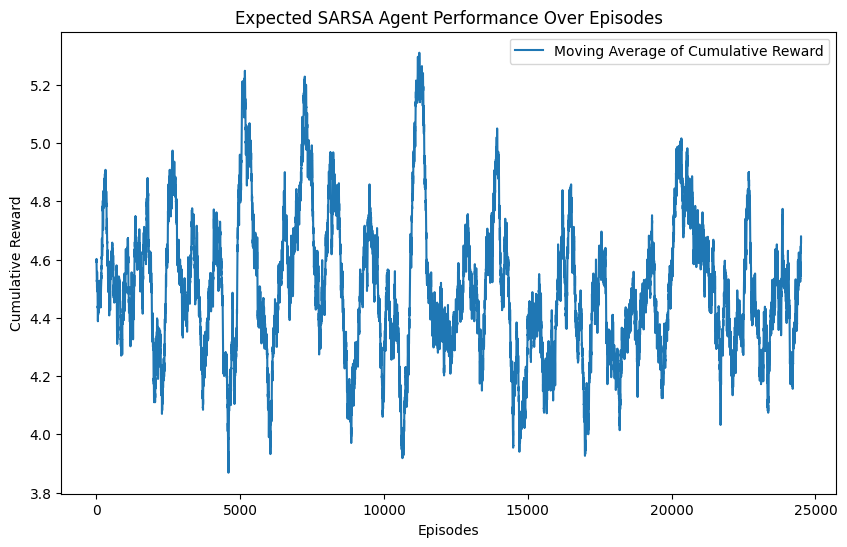

In [35]:
episodes = list(range(1, 25001))
reward_sum = [np.random.randint(-5, 15) for _ in episodes]

window_size = 500
moving_averages = []
for i in range(len(reward_sum) - window_size + 1):
    this_window = reward_sum[i : i + window_size]
    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)

plt.figure(figsize=(10, 6))
plt.plot(episodes[: len(moving_averages)], moving_averages, label='Moving Average of Cumulative Reward')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning Agent Performance Over Episodes')
plt.legend()
plt.grid(False)
plt.show()